In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import Entrez, SeqIO

In [2]:
def fetch_sequences(query, max_records=5):
    handle = Entrez.esearch(db="nucleotide", term=query, retmax=max_records)
    record = Entrez.read(handle)
    handle.close()
    
    id_list = record["IdList"]
    sequences = []
    for seq_id in id_list:
        handle = Entrez.efetch(db="nucleotide", id=seq_id, rettype="gb", retmode="text")
        seq_record = SeqIO.read(handle, "genbank")
        handle.close()
        sequences.append(seq_record.seq)
    
    return sequences

In [3]:
def sequences_to_binary_matrix(sequences, length):
    matrix = np.zeros((len(sequences), length), dtype=int)
    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq[:length]):
            if base == 'A':
                matrix[i, j] = 1
            elif base == 'C':
                matrix[i, j] = 2
            elif base == 'G':
                matrix[i, j] = 3
            elif base == 'T':
                matrix[i, j] = 4
    return matrix

# Introdução

Esse projeto consiste na aplicação da Análise de COmponentes Principais à comparação de sequências de nucleotídeos do gene Citocromo C1 (COI), que está presente no DNA mitocondrial de diferentes espécies de animais.u

O DNA funciona como o "código de barras" da vida. Sua molécula tem o formato de uma dupla-hélice, cada uma formada por uma sequência de **nucleotídeos**, que por sua vez são formados por uma pentose, fosfato e uma base nitrogenada que pode ser Adenina (A), Timina (T), Citosina (C) ou guanina (G). É comum identificarmos cada nucleotídeo que compõe a hélice do DNA através de sua base nitrogenada, e é assim que representamos amostras dessa molécula geralmente, como uma _string_ formada por caracteres A, T, G e C. A mitocôndria é uma importante organela presente em células eucariontes que, diferente das outras possui DNA próprio, o que a torna interessante para comparações evolutivas. A escolha do do gene COI para esse trabalho se deve ao fato dele estar presente em um variado grupo de espécies do reino animal, de modo a facilitar a busca de amostras para usarmos aqui.

O intuito desse projeto é comparar sequências do gene COI de diferentes animais e comparar, a luz desse gene, o quão duas espécies podem estar próximas evolutivamente, de forma a comparar também com a nossa própria noção usual de proximidade das espécies: "será que o chimpazé ficará próximo dos seres humanos?" ou "uma mosca ficará próxima de uma abelha?".

Para isso, iremos aplicar a Análise de Componentes Principais (PCA), que é um método amplamente usado no campo da bioinformática para encontar relação entre amostras de daos genéticos. O PCA é capaz de receber dados de grande dimensionalidade (neste caso, o tamanho da cadeia x o tamanho das cadeias) e reduzir ela para poucas dimensões que concentram as maiores variâncias dos dados. Desse modo, tentaremos aplicar o PCA e de modo visual observar como o grau de parentesco entre as espécies se apresenta na proximidade dos pontos que as representam sobre uma base dada pelas primeiras componentes principais.

# Metodologia e Obtenção de Dados

As amostras do gene COI froam obtidas do site GeBank do _National Canter for Biotechnology Information_ (NCBI). Cada amostra é uma sequência de caracteres A, T, C e G e a obtemos para diferentes tipos de espécies de animais. Abaixo, estão as espécies selecionadas e tentamos colocar espécies de grupos taxnonômicos próximos (como Ser Humano, Chimpazé e Camundongo como mamíferos, Mosca, Abelha, Viúva e Caranguejo como Artrópodes, etc.) a fim de comparar os resultados obtidos pelo PCA e observar se espécies de grupos taxonômicos parecidos estão próximas umas das outras. 

In [4]:
species_queries = [
    ("Ser humano", "Homo sapiens[Organism] AND COI[Gene]"),
    ("Camundongo", "Mus musculus[Organism] AND COI[Gene]"),
    ("Chimpazé", "Pan paniscus[Organism] AND COI[Gene]"),
    ("Mosca de Fruta", "Drosophila melanogaster[Organism] AND COI[Gene]"),
    ("Abelha", "Apis mellifera[Organism] AND COI[Gene]"),
    ("Caranguejo", "Limulus polyphemus[Organism] AND COI[Gene]"),
    ("Peixe zebra", "Danio rerio[Organism] AND COI[Gene]"),
    ("Carpa", "Cyprinus carpio[Organism] AND COI[Gene]"),
    ("Danio pérola", "Danio_albolineatus[Organism] AND COI[Gene]"),
    ("Sanguessuga", "Hirudo medicinalis[Oganism] AND COI[Gene]"),
    ("Minhoca", "Pontoscolex corethrurus[Organism] AND COI[Gene]"),
    ("Minhoca da terra", "Lumbricus terrestris[Organism] AND COI[Gene]"),
    ("Avestruz", "Struthio camelus[Organism] AND COI[Gene]"),
    ("Galinha", "Gallus gallus[Organism] AND COI[Gene]"),
    ("Falcão", "Falco peregrinus[Organism] AND COI[Gene]"),
    ("Rã", "Xenopus laevis[Organism] AND COI[Gene]"),
    ("Axalote", "Ambystoma mexicanum[Organism] AND COI[Gene]"),
    ("Salamandra", "Pleurodeles waltl[Organism] AND COI[Gene]"),
    ("Lesma do mar", "Aplysia californica[Organism] AND COI[Gene]"),
    ("Polvo", "Octopus vulgaris[Organism] AND COI[Gene]"),
    ("Caramujo de a. doce", "Lymnaea stagnalis[Organism] AND COI[Gene]")
]


In [5]:
Entrez.email = "jpss.joaopedross@gmail.com"
all_sequences = []
species_labels = []
for specie, query in species_queries:
    sequences = fetch_sequences(query, max_records=1)
    all_sequences.extend(sequences)
    species_labels.extend([specie] * len(sequences))

Após obter as sequências dos genes para as espécies listadas, precisamos convertê-las para um formato numérico que possa ser tratável. A solução para isso é simples, apenas iteramos sobre cada sequência e associamos um valor para cada base, de modo que nosso dicionário será

| Base | Valor |
|------|-------|
|  A   |   1   |
|  C   |   2   |
|  G   |   3   |
|  T   |   4   |

E agora temos uma estrura de dados na forma da uma matriz em que cada linha é uma espécie e cada coluna é a posição de um nucleotídeo do gene COI. Com isso, estamos aptos a aplicar o PCA sobre os dados. A forma escolhida para obter as componentes principais foi através da Decomposição de Valores SIngulares (SVD) da nossa matriz $M$ espécies por nucleotídeos. Pela especificação da decomposição SVD, dada por $$ M = E \times \Sigma \times N^t $$em que M é a nossa matriz original, $E$ e $N$ são matrizes ortogonais e $\Sigma$ é uma matriz diagonal com os valores singulares de $M$, de modo que as componentes principais que servem como uma base ortonormal para as espécies são as colunas da matriz $E$.

Por questões de vizualizações, utilizamos duas matrizes $M$, uma $M_{e, 100}$ e outra $M_{e, 300}$. A primeira será utilizada para vizualizarmos a "reconstrução" da matriz original, e a segunda vermos as espécies em dimensão reduzida. 

In [6]:
matrix_for_spectral = sequences_to_binary_matrix(all_sequences, length=100)
matrix_for_pca = sequences_to_binary_matrix(all_sequences, length=300)


E_spec, Sig_spec, N_spec = np.linalg.svd(matrix_for_spectral, full_matrices=False)
E, Sig, N = np.linalg.svd(matrix_for_pca, full_matrices=False)

def rec_matrix(U, Sig, Vt, k):
    return U[:, :k] @ np.diag(Sig[:k]) @ Vt[:k, :]


PC1 = Sig[0] * E[:, 0]
PC2 = Sig[1] * E[:, 1] 
PC3 = Sig[2] * E[:, 2]

# Resultados

Abaixo, está nossa matriz $M_{e,\ 100}$ reconstruída com diferentes quantidades de componentes principais. Aqui se justifica nossa escolha de organizarmos as amostras de sequências de modo que grupos taxonômicos semelhantes estejam em linhas consecutivas. Percebamos, na reconstrução com 2 componentes principais, como que espécies taxonomicamente próximas, salvo algumas exceções, são semelhantes quanto o aspecto das "barras" que formam as linhas, como se cada grupo tivesse um "código de barras". Conforme, aumentamos o número de componentes principais, mais próximos estamos do aspecto da matriz original e mais diferentes vão ficando as espécies individualmente.

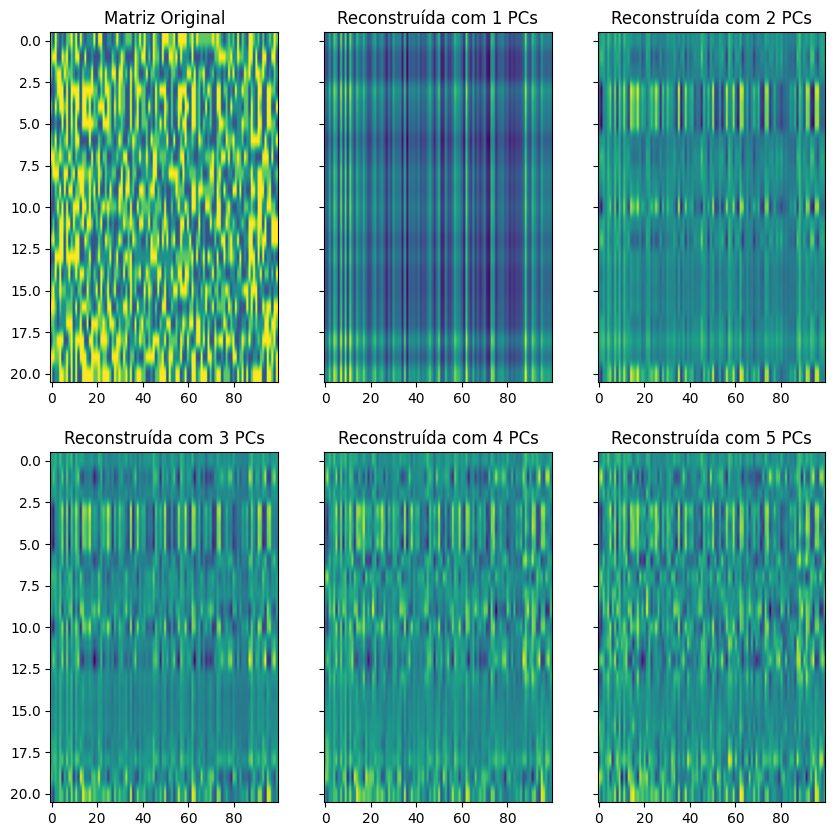

In [7]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=3, sharey=True)

k = 0
for i in range(2):
    for j in range(3):
        if i == 0 and j == 0:
            M = matrix_for_spectral
            axes[i, j].set_title('Matriz Original')
        else:
            M = rec_matrix(E_spec, Sig_spec, N_spec, k)
            axes[i, j].set_title(f'Reconstruída com {k} PCs')
        k += 1
        axes[i, j].imshow(M, cmap='viridis', aspect='auto')




Na próxima imagem, encontram-se as espécies (com nomes genéricos) representadas em duas dimensões cuja base é formada pelas duas primeiras componentes principais.

Daqui podemos fazer várias observações, como 

- Os mamíferos Ser Humanos e Chimpazé estão mais próximos entre si do que dos camundongos.

- Os artrópodes mosca, abelha, caranguejo estão bem próximos entre si.

- Os moluscos Polvo e Lesma do mar estão bem róximos quanto a segunda componente, porém mais distantes quanto a primeira. O caramujo de água doce, também um molusco, parece estar distante dos outros nas duas componentes.

- Os anfíbios rã e axalote estão bem próximas tanto na primeira quanto na segunda componente, porém estão da salamandra quanto a segunda componente.

- O peixe-zebra, a carpa e o danio pérola estão mais próximos entre si na segunda componente do que na primeira.

- Os anelídeos minhoca, minhoca da terra e sanguessuga estão mais próximos entre si na primeira componente do que na segunda.

- As aves galinha e avestruz estão mais próximas entre si do que essas do falcão.

Também temos que animais de grupos taxonômicos mais distantes conservam certa semelhança em algumas componentes, como peixe-zebra e avestruz nos PC1 e PC2, sanguessuga e rã no PC2, etc. 

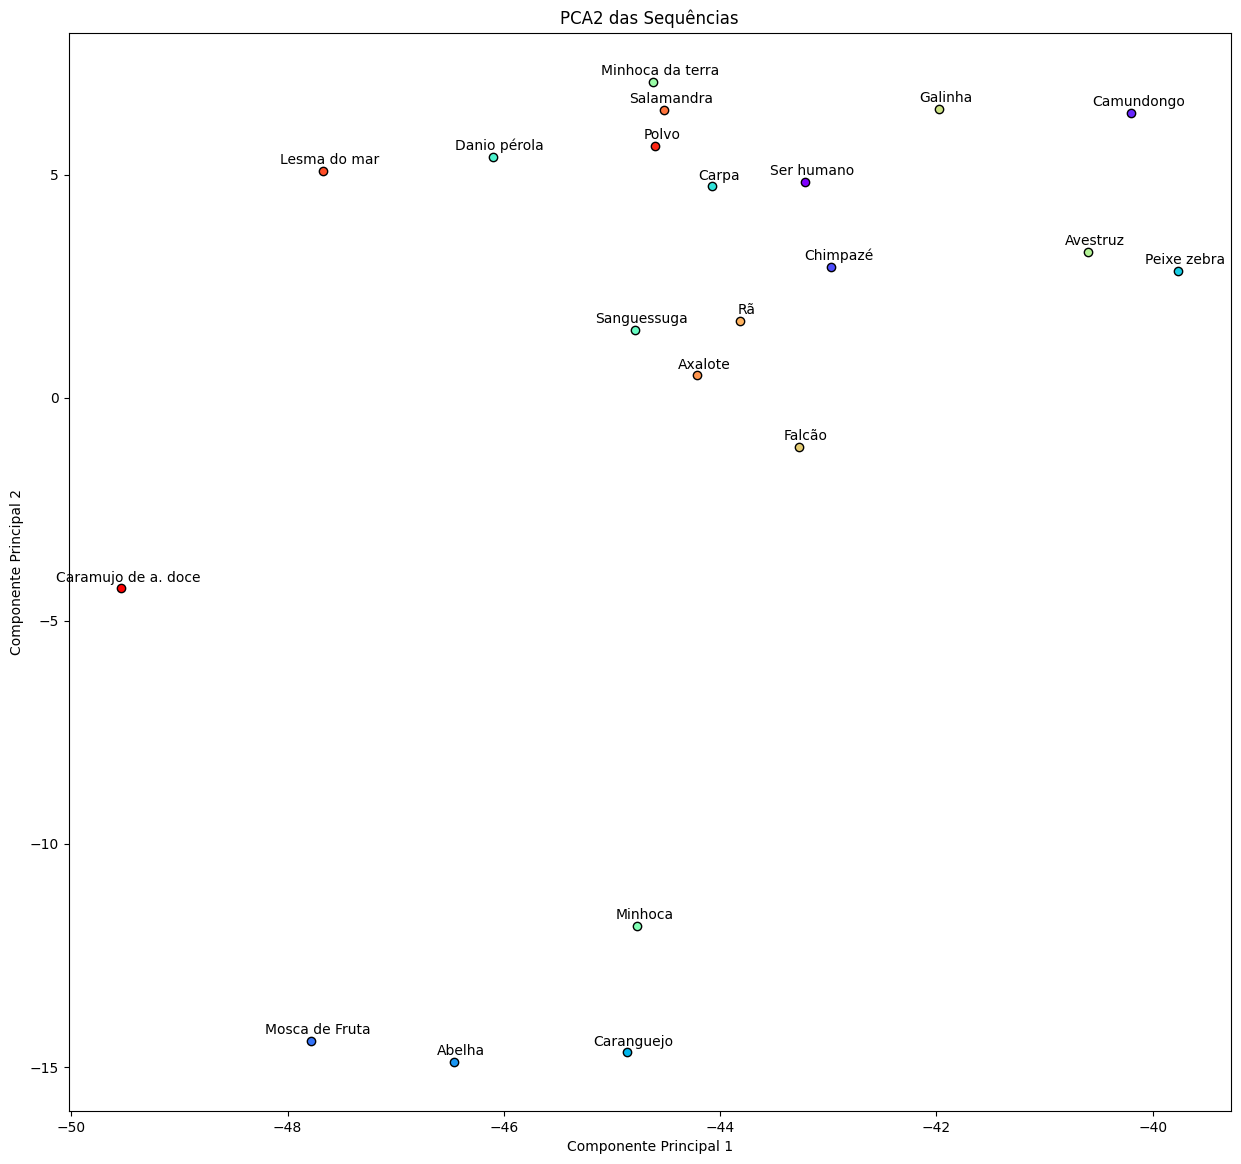

In [8]:
colors = np.array(plt.cm.rainbow(np.linspace(0, 1, len(species_queries))))

plt.figure(figsize=(15, 14))
for k, species in enumerate(species_labels):
    plt.scatter(PC1[k], PC2[k], label=species, color=colors[k], edgecolors='k')

for k, specie in enumerate(species_labels):
    plt.annotate(specie, (PC1[k], PC2[k]), textcoords="offset points", xytext=(5,5), ha='center')


#plt.legend()
plt.title('PCA2 das Sequências')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

Abaixo, representamos as espécies agora em dimensão 3, podemos observar mudanças significativas na configuração anterior, como o Chimpazé está mais próximo do polvo do que do ser humano, assim como a rã está mais próxima do polvo do que da axalote.

Text(0.5, 0, 'Componente Principal 3')

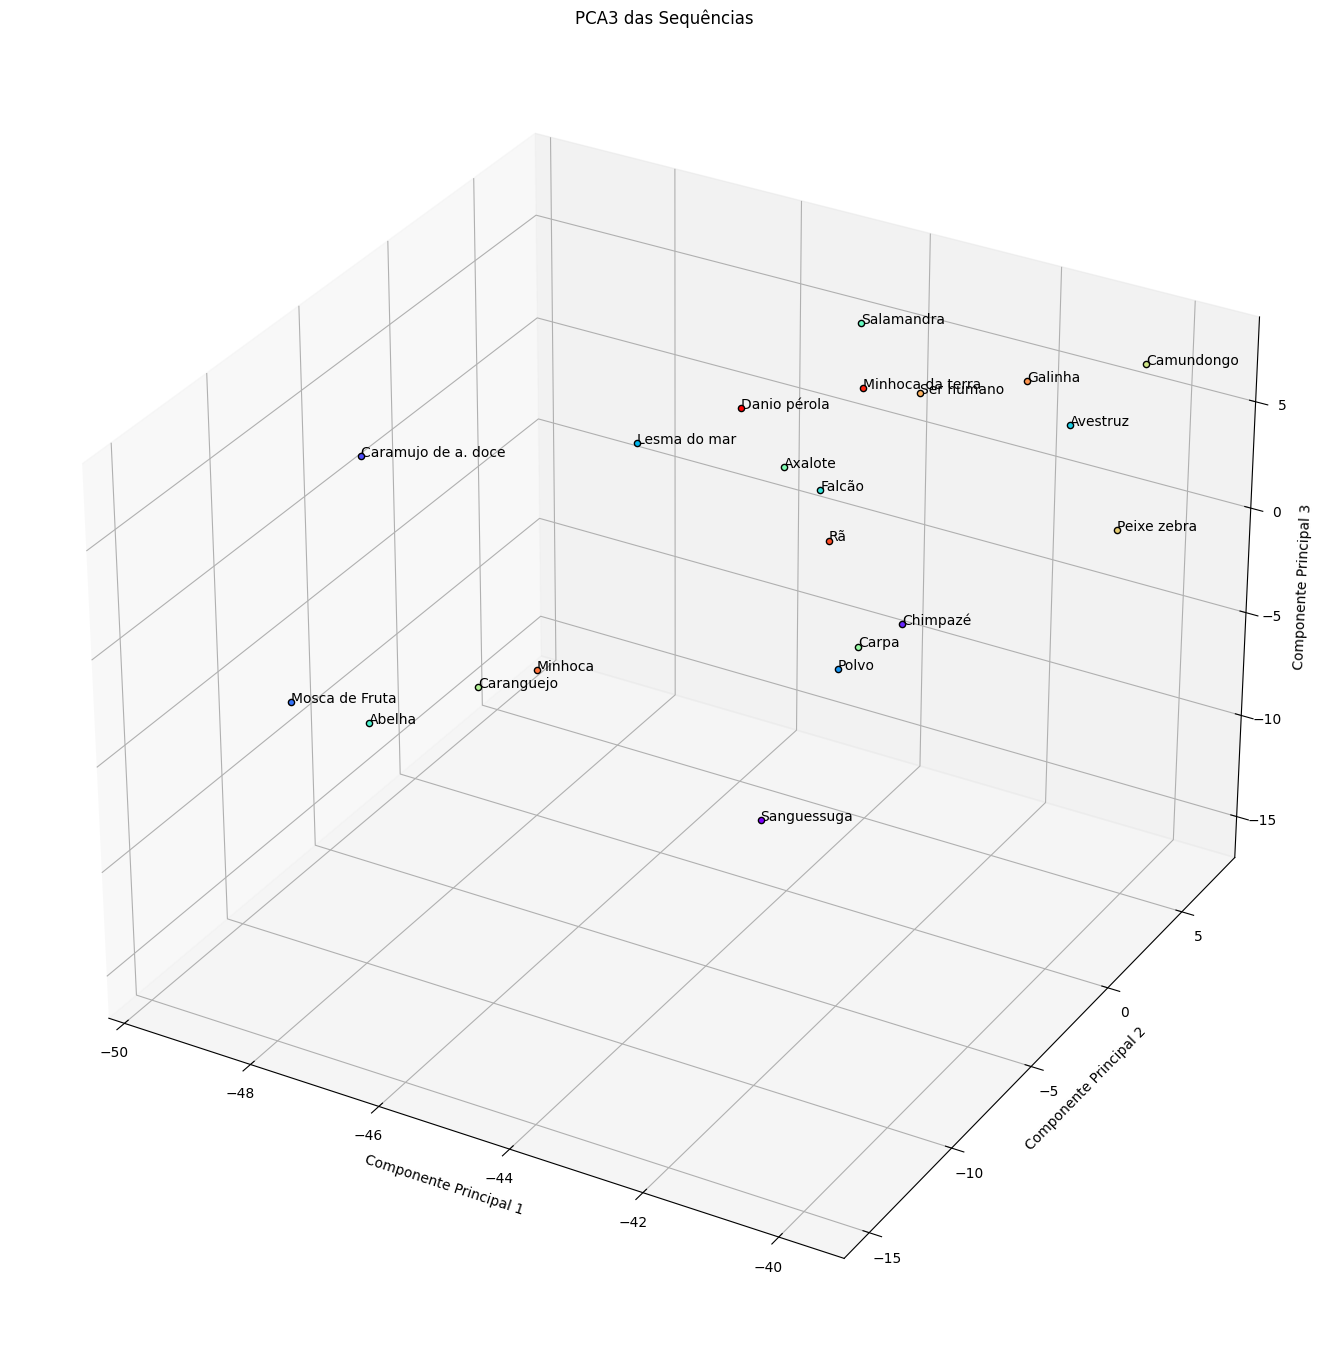

In [80]:
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(111, projection='3d')

colors = np.array(plt.cm.rainbow(np.linspace(0, 1, len(species_queries))))

# Plotagem dos dados
for k, species in enumerate(set(species_labels)):
    indices = [i for i, label in enumerate(species_labels) if label == species]
    ax.scatter(PC1[indices], PC2[indices], PC3[indices], color=colors[k], label=species, edgecolors='k')

# Adição dos rótulos
for k, specie in enumerate(species_labels):
    ax.text(PC1[k], PC2[k], PC3[k], specie, size=10, zorder=1, color='k')

# Definição dos rótulos dos eixos e título
ax.set_title('PCA3 das Sequências')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')


No gráfico abaixo, percebemos que boa parte da variância (cerca de 83%) nos dados encontram-se na primeira componente principal. O fit de ajuste do PCA encontra-se nas duas primeiras componentes principais, o que segere que as variâncias explicadas nas demais componentes são reuídos.

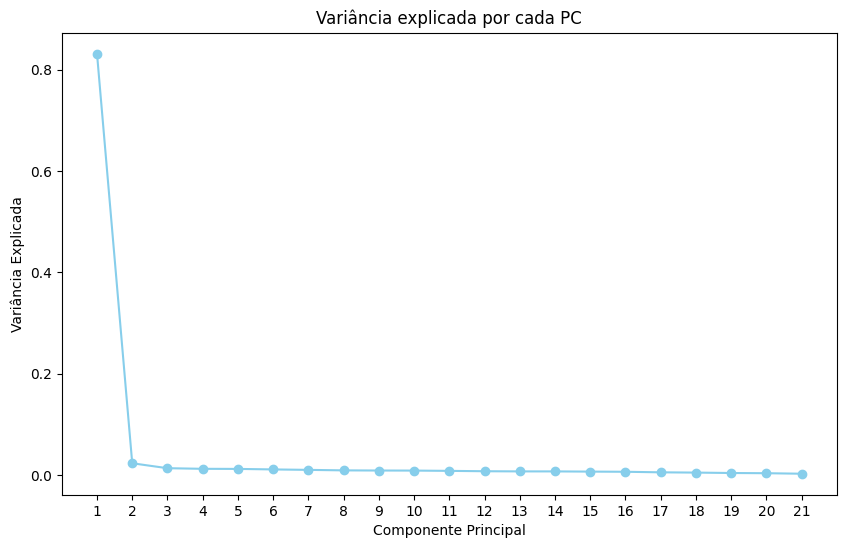

In [10]:
variance = Sig ** 2 / np.sum(Sig ** 2)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(Sig) + 1), variance, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')
plt.title('Variância explicada por cada PC')
plt.xticks(range(1, len(Sig) + 1))
plt.show()

Text(0.5, 1.0, 'Variância total nos grupos em PC1')

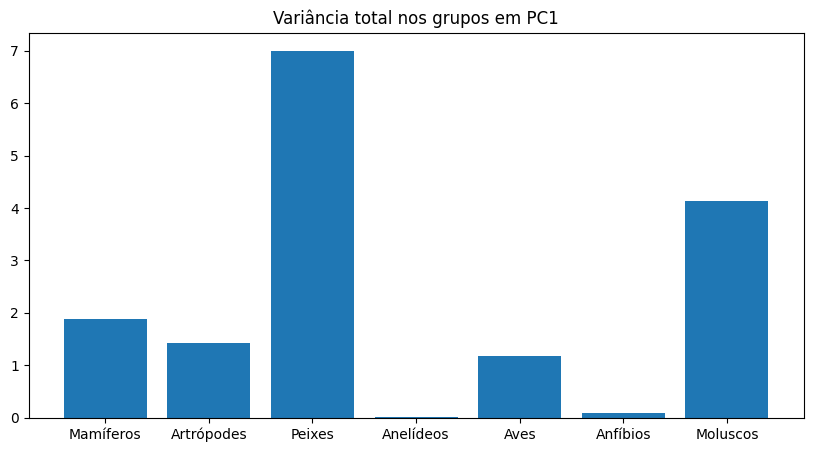

In [64]:
def variance_in_group(E, Sig, k, i, j):
    E_ = E[:, :k] @ np.diag(Sig[:k])
    return np.array(np.var(E_[i:j], axis=0, ddof=0))

grupos = ["Mamíferos", 'Artrópodes', 'Peixes', 'Anelídeos', 'Aves', 'Anfíbios', 'Moluscos']

variancia_em_grupos_2d = {
    grupo: variance_in_group(E, Sig, 2, i*3, i*3+3) for i, grupo in enumerate(grupos)
}


variancia_x = np.array([valor[0] for valor in variancia_em_grupos_2d.values()])
variancia_y = np.array([valor[1] for valor in variancia_em_grupos_2d.values()])
variancia_total = variancia_x + variancia_y

plt.figure(figsize=(10, 5))
plt.bar(grupos, variancia_x)
plt.title("Variância total nos grupos em PC1")


Text(0.5, 1.0, 'Variância total nos grupos em PC2')

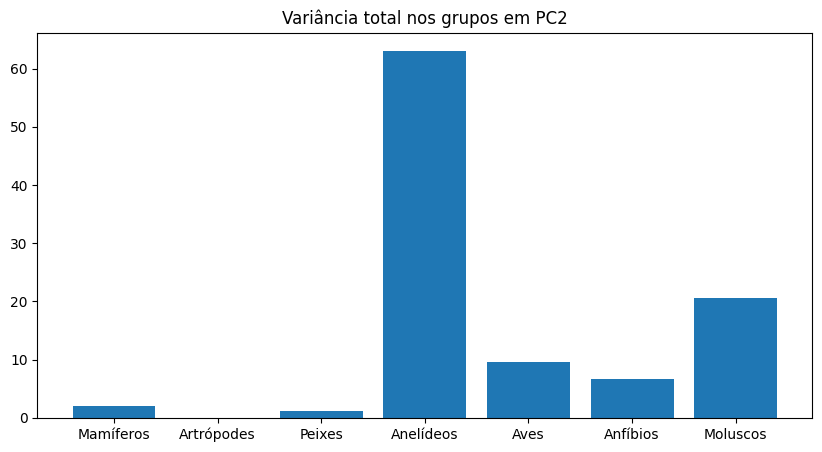

In [79]:
plt.figure(figsize=(10, 5))
plt.bar(grupos, variancia_y)
plt.title("Variância total nos grupos em PC2")